In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import lightgbm as lgb
import warnings

In [ ]:
pip install japanize-matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 55.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=9a5554104b76590e9c05846e371fcb442ee4145b72e95028942c6a074abf4d29
  Stored in directory: /root/.cache/pip/wheels/4f/ca/96/4cc5e192421cceb077fbf4ffec533382edd416fd3fa0af0bbd
Successfully built japanize-matplotlib


In [ ]:
import japanize_matplotlib

In [ ]:
df = pd.read_csv("mid.csv",encoding ='UTF-8')

In [ ]:
df = df.drop(["種類","都道府県名"], axis=1)

In [ ]:
df = df.drop(["今後の利用目的", "取引の事情等"], axis=1)

In [ ]:
def data_preprocess(df):
  cat_fetures = ["市区町村名", "地区名", "最寄駅：名称", "間取り", "建物の構造", "用途",  "都市計画", "改装"]
  for col in cat_fetures:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(df[col])
    lbl.transform(df[col])
    df[col] = lbl.transform(df[col])
  return df

df =data_preprocess(df)

In [ ]:
pip install autofeat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.5/269.5 KB 13.1 MB/s eta 0:00:00


In [ ]:
from autofeat import AutoFeatRegressor   

In [ ]:
df = df.dropna()
df.isnull().sum()

市区町村名        0
地区名          0
最寄駅：名称       0
最寄駅：距離（分）    0
取引価格（総額）     0
間取り          0
面積（㎡）        0
建物の構造        0
用途           0
都市計画         0
建ぺい率（％）      0
容積率（％）       0
取引時点         0
改装           0
築年数          0
dtype: int64

In [ ]:
X = df.drop(["取引価格（総額）"], axis=1)
y = df["取引価格（総額）"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
af = AutoFeatRegressor(verbose=1)

In [ ]:
X_train_feature_creation = af.fit_transform(X_train, y_train)

[AutoFeat] The 2 step feature engineering process could generate up to 4851 features.
[AutoFeat] With 58331 data points this new feature matrix would use about 1.13 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 53 transformed features from 14 original features - done.
[feateng] Step 2: first combination of features


/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:246: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


[feateng] Generated 2188 feature combinations from 2211 original feature tuples - done.
[feateng] Generated altogether 2252 new features in 2 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 1330 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 196 features after 5 feature selection runs
[featsel] 148 features after correlation filtering
[featsel] 84 features after noise filtering
[AutoFeat] Computing 80 new features.
[AutoFeat]    80/   80 new features ...done.
[AutoFeat] Final dataframe with 94 feature columns (80 new).
[AutoFeat] Training final regression model.
[AutoFeat] Trained model: largest coefficients:
13190155.926047144
80371.464276 * 面積（㎡）
-48679.732603 * sqrt(改装)*築年数
29271.593746 * sqrt(用途)*面積
-6936.256519 * 築年数*面積


In [ ]:
print("number of features in X_train:",  #元の特徴量Xの数
      X_train.shape[1])                                   
print("number of features in X_train_feature_creation:", 
      X_train_feature_creation.shape[1]) #新しい特徴量Xの数

number of features in X_train: 14
number of features in X_train_feature_creation: 94


In [ ]:
X_test_feature_creation = af.transform(X_test)

[AutoFeat] Computing 80 new features.
[AutoFeat]    80/   80 new features ...done.


In [ ]:
model = lgb.LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',
    n_estimators=1000,
    )
    
model.fit(X_train_feature_creation, y_train)

y_pred = model.predict(X_test_feature_creation)

In [ ]:
print("平均二乗誤差 (MSE): ", mean_squared_error(y_test, y_pred)) 
print("二乗平均平方根誤差(RMSE): ", mean_squared_error(y_test, y_pred, squared=False)) 
print("平均絶対誤差 (MAE): ", mean_absolute_error(y_test, y_pred)) 
print("決定係数(R2): ", r2_score(y_test, y_pred)) 
print("平均絶対誤差率(MAPE): ", np.mean(np.abs((y_pred - y_test) / y_test)) * 100) 

平均二乗誤差 (MSE):  11273346609519.227
二乗平均平方根誤差(RMSE):  3357580.4695523274
平均絶対誤差 (MAE):  2314139.5228874027
決定係数(R2):  0.8764455053951168
平均絶対誤差率(MAPE):  60.42539249346315


In [ ]:
print('学習データに対する決定係数(R2): {}'.format(model.score(X_train_feature_creation, y_train)))
print('テストデータに対する決定係数(R2): {}'.format(model.score(X_test_feature_creation, y_test)))

学習データに対する決定係数(R2): 0.9422574227255046
テストデータに対する決定係数(R2): 0.8764455053951168


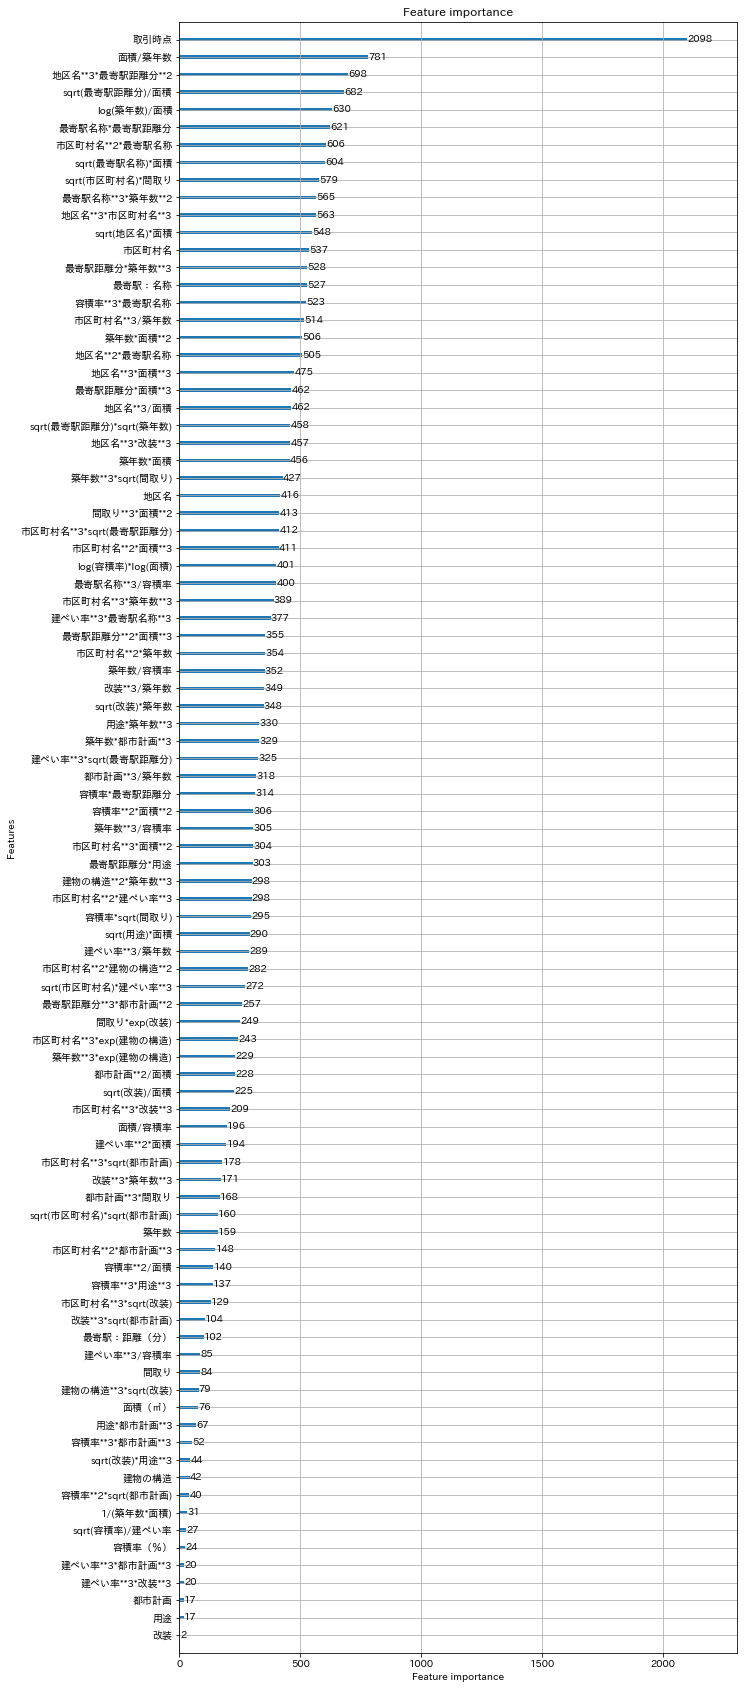

In [ ]:
lgb.plot_importance(model, importance_type='split', figsize=(10,30))
plt.show()

In [ ]:
plt.figure(figsize=(5, 5)) 
plt.plot([0,y_test.max()], [0,y_test.max()], label="y=x", color="black")
plt.scatter(y_pred, y_test)
plt.legend()
plt.xlim(0, y_test.max())
plt.ylim(0, y_test.max())
plt.xlabel("predict")
plt.ylabel("true")
plt.show()

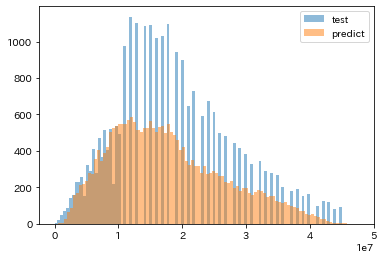

In [ ]:
plt.hist(y_test, bins=100, alpha=0.5, label="test")
plt.hist(y_pred, bins=100, alpha=0.5, label="predict")
plt.legend()
plt.show()